In [1]:
#!/usr/bin/python

import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mp
import datetime
import os
#import seaborn as sns
#sns.set()
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('/home2/datahome/cdemarez/MODULES_PY') 

from tools import *
from croco_tools_cdm import *
from plot_tools import *

import matplotlib.patches as patches

In [2]:
#path a changer pour differents run

path1 = '/home2/datawork/cdemarez/Needs/V1'
#path2 = '/home2/scratch/cdemarez/LEEWA/final'
#path3 = '/home/datawork-lops-oh/meddle/cdemarez/final_2'
path2 = '/home2/scratch/cdemarez/LEEWA/finalv2'

In [3]:
#load parameters of the simulation
h,lon,lat,mask,f,time_ini,pm,pn,angle=load_param_simulation(path1)

('date du fichier ini:', datetime.date(2016, 3, 20))


In [4]:
#load a few parameters from simulation output

file='/leewa_avg.00360.nc' 

step=12
ncfile=path2+file
nc = Dataset(ncfile)
rho0=getattr(nc,'rho0')
hc=getattr(nc,'hc')
Cs_r=getattr(nc,'Cs_r')
Cs_w=getattr(nc,'Cs_w')
g=9.81

nc.close()

print('load from ',ncfile)

('load from ', '/home2/scratch/cdemarez/LEEWA/finalv2/leewa_avg.00360.nc')


# Choose loc of section

In [5]:
#isolated seamounts 
lonsec=[-79.46,-79.35]
latsec=[30.55,30.8]



pathsave_figs='./'


try:
	os.mkdir(pathsave_figs)
except OSError:
	pass




### Get the variables

In [6]:

file='/sections_filtered.nc'
ncfile=pathsave_sect+file

nc = Dataset(ncfile)
print(nc.variables.keys())
x= nc.variables['x'][:]
z= nc.variables['z'][:]
h= nc.variables['h'][:]
#x_h= nc.variables['x_h'][:]
f= nc.variables['f'][:]
hbbl= nc.variables['hbbl'][:]
w= nc.variables['w'][:]
rho= nc.variables['rho'][:]
u= nc.variables['u'][:]
v= nc.variables['v'][:]
bvf2= nc.variables['bvf2'][:]
#AKt= nc.variables['AKt'][:]
#AKv= nc.variables['AKv'][:]
if file=='/sections_all.nc': time= nc.variables['time'][:]
else : time=np.arange(len(w[:,0,0]))
nc.close()
U=np.sqrt(u**2+v**2)



[u'x', u'z', u'h', u'f', u'hbbl', u'w', u'rho', u'u', u'v', u'bvf2', u'AKv', u'AKt']


In [7]:
if len(time)==1:
    step_file=0
    date=print_date(time[step_file]*3600)
    print ("Date de la section :",datetime.date(int(date[0]), int(date[1]), int(date[2])))
    
else : 
    print (int(1+time[-1]/24), " jours de simulations dans le .nc")
    
    ######A CHOISIR####
    step_file=372#130
    ###################
    
    date=print_date(time[step_file]*3600)
    print ("Date de la section choisie :",datetime.date(int(date[0]),int(date[1]), int(date[2])))

(24, ' jours de simulations dans le .nc')
('Date de la section choisie :', datetime.date(2016, 4, 5))


# Compare with my theory code 3D

# I- FROM SECTION

In [8]:
nc = Dataset('./theory_3D_section_{}_{}_{}_{}_radinf_WKBJ_little.nc'.format(lonsec[0],lonsec[1],latsec[0],latsec[1]))
print(nc.variables.keys())
x_th=nc.variables['x'][:]/1000
y_th=nc.variables['y'][:]/1000
z_th=nc.variables['z'][:]
h_th=nc.variables['topo'][:]
w_hydro_th=nc.variables['w'][:]
u_hydro_th=nc.variables['u'][:]
v_hydro_th=nc.variables['v'][:]
P_hydro_th=nc.variables['P'][:]
rho_hydro_th=nc.variables['rho'][:]



prof_U_th=nc.variables['U_prof'][:]
prof_Uzz_th=nc.variables['Uzz_prof'][:]
prof_bvf_th=nc.variables['bvf_prof'][:]
idx_sect=int(nc.variables['idx_section'][0])  ##just to know where is the section

nc.close()
#isolated seamount
h_th=h_th-np.abs(np.min(z))
z_th=z_th-np.abs(np.min(z))
#on the bump
#h_th=h_th-np.abs(np.median(-h))
#z_th=z_th-np.abs(np.median(-h))
#x_th=x_th-8


#for sections
xx_v,zz_v=np.meshgrid(x_th,z_th) 
xx_h,yy_h=np.meshgrid(x_th,y_th) 

[u'x', u'y', u'z', u'topo', u'U_prof', u'Uzz_prof', u'bvf_prof', u'idx_section', u'w', u'u', u'v', u'P', u'rho', u'Divergence', u'Strain']


## compare w side view

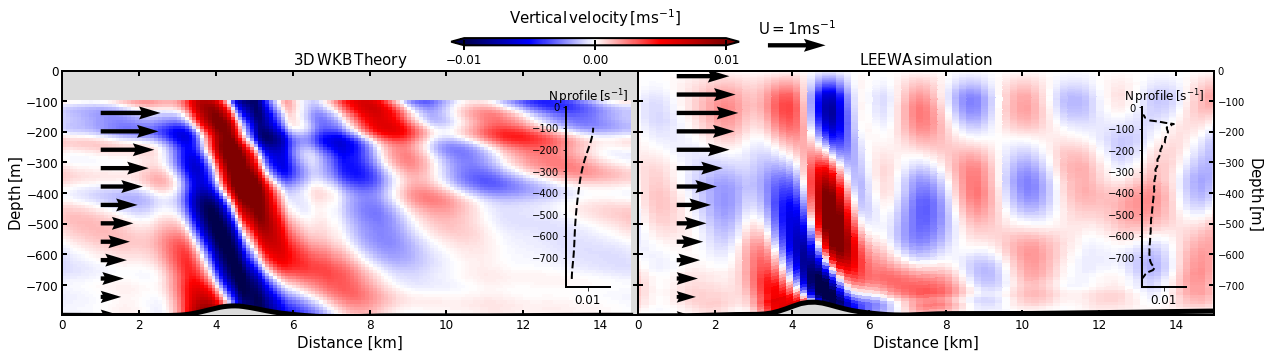

In [9]:
#pour tracer des profils de vitesse sur les plots
prof_U_tmp=np.nanmean(U[step_file,:,:],axis=1)
prof_bvf2_tmp=np.nanmean(bvf2[step_file,:,:],axis=1)
prof_bvf_tmp=np.sqrt(prof_bvf2_tmp)

from scipy import interpolate



N_sub=2

fig=plt.figure(figsize=(N_sub*10,5))


minp=-0.01
maxp=0.01




for i in range(N_sub):
    ax=plt.subplot(1,N_sub,i+1)

    
    if i==1:

        plt.title(r'${\rm LEEWA\, simulation}$',fontsize=15)

        #### WHAT we plot#####
        x_tmp=x-8
        #x_tmp=x
        
        pc=plt.pcolormesh(x_tmp,z,w[step_file,:,:],cmap='seismic',vmin=minp,vmax=maxp)
        
              
        #prof of velocity
        f = interpolate.interp1d(z[:,0], prof_U_tmp)
        prof_z=np.arange(np.min(z[:,0]),np.max(z[:,0]),10)
        prof_U=f(prof_z)
        nshow=int(len(prof_U)/12)
        Q=plt.quiver(1*np.ones(prof_z[::nshow].shape),prof_z[::nshow],
                     prof_U[::nshow],np.zeros(prof_z[::nshow].shape),scale=10)
        #lines
        plt.plot(x_tmp[0,:],-h[:],'-k',linewidth=5)
        #plt.plot(x[0,:],z_bml_all[step_file],'--',label='BML',linewidth=2,color='gray')
        
        
        ######################
        #plt.axis([np.min(xx_v[0,:]),np.max(xx_v[0,:]),np.min(z[:,:]),np.max(z[:,:])])
        plt.axis([0,15,np.min(z[:,:]),np.max(z[:,:])])
        
        
        #plt.axis([np.min(x_tmp[0,:]),np.max(x_tmp[0,:]),np.min(z[:,:]),np.max(z[:,:])])
        
        plt.xlabel('Distance [km]',fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(np.arange(0,-800,-100),fontsize=0.01)
        plt.ylabel(r'${\rm Depth\, [m]}$',fontsize=15,labelpad=20,rotation=-90)
        ax.yaxis.set_label_position("right")
        ax.yaxis.set_ticks_position("right")
        ax.spines['left'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)       
        ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)   

        
        
        
        plt.rcParams['axes.facecolor'] = (1,1,1,0)
        prof_ax=fig.add_axes([0.85, 0.2, 0.03, 0.5])
        plt.title(r'${\rm N\,profile \,[s^{-1}]}$')
        plt.plot(prof_bvf_tmp,z[:,0],'--k',linewidth=2)
        plt.xticks([1.e-2],fontsize=12)
        plt.yticks(np.arange(0,-800,-100))
        #prof_ax.tick_params(labelleft='off') 
        prof_ax.set_xlim(0,2.e-2)
        #prof_ax.set_ylim(np.min(z_prof),0)
        prof_ax.spines['top'].set_linewidth(0)
        prof_ax.spines['left'].set_linewidth(2)
        prof_ax.spines['bottom'].set_linewidth(2)
        prof_ax.spines['right'].set_linewidth(0)
        #plt.grid(linewidth=2)
        plt.rcParams['axes.facecolor'] = 'gainsboro'

    
    
    
    elif i==0:
        plt.title(r'${\rm 3D\,WKB\,Theory\,}$',fontsize=15)
    
    
        #### WHAT we plot#####
        decx=00
        pc=plt.pcolormesh(xx_v-decx,zz_v,w_hydro_th[:,idx_sect+1,:],cmap='seismic',vmin=minp,vmax=maxp)

        '''
        pc=plt.pcolor(xx_v,zz_v,w_hydro_th[:,idx_center,:],cmap='bwr',vmin=-0.1,vmax=0.1,alpha=0.2)

        plt.contour(xx_v[:,1:],zz_v[:,1:],w_hydro_th[:,idx_center,:],
                    np.array([-0.01,0.01]),colors='k')
        '''
        plt.plot(x_th-decx,h_th[idx_sect+1,:],'-k',linewidth=5,zorder=11)
        plt.fill(x_th-decx,h_th[idx_sect+1,:]-1,'-k',facecolor='gainsboro',linewidth=5,zorder=10)
        nshow2=int(len(prof_U_th)/11)
        Q=plt.quiver(1*np.ones(z_th[::nshow2].shape),z_th[::nshow2],
                     prof_U_th[::nshow2],np.zeros(z_th[::nshow2].shape),scale=10)
        #Q=plt.quiver(1*np.ones(z_th[::nshow2].shape),z_th[::nshow2],
        #             np.nanmean(prof_U_th)*np.ones(prof_U_th[::nshow2].shape),np.zeros(z_th[::nshow2].shape),scale=10)
    
        ######################
        plt.axis([0,15,np.min(z[:,:]),np.max(z[:,:])]) #if th is smaller
        #plt.axis([np.min(xx_v[0,:]),np.max(xx_v[0,:]),np.min(z[:,:]),np.max(z[:,:])]) #if th is smaller
        #plt.axis([np.min(x_tmp[0,:]),np.max(x_tmp[0,:]),np.min(z[:,:]),np.max(z[:,:])]) #if th is bigger
        
        plt.xlabel('Distance [km]',fontsize=15)
        plt.xticks(fontsize=12)
        plt.ylabel(r'${\rm Depth\, [m]}$',fontsize=15,labelpad=0,rotation=90)
        plt.yticks(np.arange(0,-800,-100),fontsize=12)
        ax.spines['left'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)       
        ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)  
    
    
    
        plt.rcParams['axes.facecolor'] = (1,1,1,0)
    
        prof_ax=fig.add_axes([0.45, 0.2, 0.03, 0.5])
        plt.title(r'${\rm N\, profile\,[s^{-1}]}$')
        plt.plot(prof_bvf_th,z_th,'--k',linewidth=2)
        #plt.plot(np.nanmean(prof_bvf_th)*np.ones(prof_bvf_th.shape),z_th,'--k',linewidth=2)
        plt.xticks([1.e-2],fontsize=12)
        plt.yticks(np.arange(0,-800,-100))
        #prof_ax.tick_params(labelleft='off') 
        prof_ax.set_xlim(0,2.e-2)
        #prof_ax.set_ylim(np.min(z_prof),0)
        prof_ax.spines['top'].set_linewidth(0)
        prof_ax.spines['left'].set_linewidth(2)
        prof_ax.spines['bottom'].set_linewidth(2)
        prof_ax.spines['right'].set_linewidth(0)    
        #plt.grid(linewidth=2)
        plt.rcParams['axes.facecolor'] = 'gainsboro'
        
 
    
    
    

    
    

    
qk=ax.quiverkey(Q, X=0.61, Y=0.87, U=1,
             label=r'${\rm U=1ms^{-1}}$',fontproperties={'size':15}, labelpos='N',coordinates='figure')
#t = qk.text.set_backgroundcolor('g')
    
cbar_ax = fig.add_axes([0.37, 0.87, 0.2, 0.02])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=[minp,0,maxp])
#cbar.set_label(r"${\rmDensisty \,[ kg.m^{-3}]}$", fontsize=15, 	rotation=0,labelpad=-55)
cbar.set_label(r"${\rm Vertical\, velocity \,[ ms^{-1}]}$", fontsize=15, 	rotation=0,labelpad=-60)
#cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(labelsize=12,direction='inout',width=2,length=10)
    
    

plt.subplots_adjust(left=0.1,bottom=0.12,right=0.9,top=0.8,wspace=0.0)  

#plt.savefig(pathsave_figs+'/compare_w_3Dc_LEEWA.png',dpi=200)

plt.show()

In [10]:
###Save the section value to plot after on the big fancy plot

x_sect_leewa=x_tmp
z_sect_leewa=z
w_sect_leewa=w[step_file,:,:]
prof_U_sect_leewa=prof_U_tmp
prof_bvf_sect_leewa=prof_bvf_tmp #plot it against z_sect_leewa[:,0]
h_sect_leewa=h

x_sect_th=x_th-decx
z_sect_th=zz_v
w_sect_th=w_hydro_th[:,idx_sect+1,:]
prof_U_sect_th=prof_U_th
prof_bvf_sect_th=prof_bvf_th
h_sect_th=h_th[idx_sect+1,:]

## Compare what is happening at the bottom 

In [11]:
#load flux calculation


file='./sections_all_flux.nc'

ncfile=file

nc = Dataset(ncfile)
print(ncfile)
print(nc.variables.keys())
x= nc.variables['x'][:]
z= nc.variables['z'][:]
h= nc.variables['h'][:]


u_prime= nc.variables['u'][:]
v_prime= nc.variables['v'][:]
w_prime= nc.variables['w'][:]
P_prime= nc.variables['P'][:]




if len(time)==1:
    step_file=0
    date=print_date(time[step_file]*3600)
    print ("Date de la section :",datetime.date(int(date[0]), int(date[1]), int(date[2])))
    
else : 
    print (int(1+time[-1]/24), " jours de simulations dans le .nc")
    
    ######A CHOISIR####
    step_file=372
    ###################
    
    date=print_date(time[step_file]*3600)
    print ("Date de la section choisie :",datetime.date(int(date[0]),int(date[1]), int(date[2])))

/home2/datahome/cdemarez/Diagnostics/LEEWA/Diags_v3/section_-79.46_-79.35_30.55_30.8/sections_all_flux.nc
[u'time', u'x', u'z', u'h', u'x_h', u'P', u'u', u'v', u'w']
(24, ' jours de simulations dans le .nc')
('Date de la section choisie :', datetime.date(2016, 4, 5))


In [12]:
#take only the moment of apparition of a wave and make an average over the event
if file=='/sections_all_flux.nc'or file=='/sections_all_flux_LR.nc' :
    #ideali seamount
    istart=300
    iend=400
    #on the bump
    #istart=120
    #iend=200
    dt=(iend-istart)/24
    print('average on ',dt,'days')

    P_mean=np.mean(P_prime[istart:iend,:],axis=0)
    w_mean=np.mean(w_prime[istart:iend,:],axis=0)
    FeZ_mean=P_mean*w_mean
else :
    P_mean=P_prime
    w_mean=w_prime
    FeZ_mean=P_mean*w_mean


('average on ', 4, 'days')


Take only the bottom in order to compare it with theory

In [13]:
#watch out ! for the simulation fluxes, z dimension is from the top
def take_bottom (signal,x):
    signal=signal[::-1,:]
    sig_bottom=np.zeros(x[0,:].shape)
    test_nan=np.isnan(signal)
    for ix in range (len(sig_bottom)):
        for iz in range(1,signal.shape[0],1):
            if test_nan[iz,ix]==False:
                sig_bottom[ix]=signal[iz,ix]
                #print(ix,iz)
                break  
    return sig_bottom

In [14]:
P_bottom=take_bottom(P_mean[:,:],x)
w_bottom=take_bottom(w_mean[:,:],x)
FeZ_bottom=P_bottom*w_bottom

adjust the domain with the topo

In [15]:
#isolated seamount

x_peak_th=x_th[np.argmax(h_th[idx_sect+1,:])]
x_peak_leewa=x[0,np.argmax(-h)]
decale_x=x_peak_leewa-x_peak_th
x_dec=x[0,:]-decale_x


#x_dec=x[0,:]

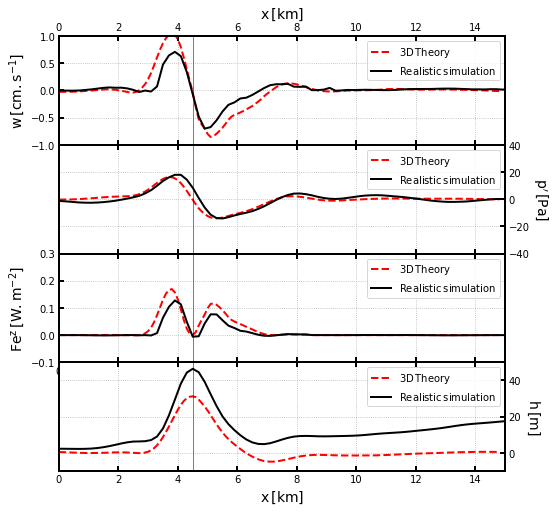

In [16]:
#theoretical fluxes:
FeZ_hydro_th=w_hydro_th*P_hydro_th

fig=plt.figure(figsize=(8,8))

#isolated seamount
xl1=0
xl2=15
#on the bump
#xl1=0
#xl2=50

ax=plt.subplot(411,facecolor='w')
plt.plot(x_th,w_hydro_th[0,idx_sect+1,:]*100,'--r',linewidth=2,label=r'${\rm 3D \,Theory}$')
plt.plot(x_dec,w_bottom*100,'-k',linewidth=2,label=r'${\rm Realistic\, simulation}$')
plt.plot([x_peak_th,x_peak_th],[-100,100],'-k',linewidth=1,alpha=0.5)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
plt.ylabel(r'${\rm w\, [cm.s^{-1}]}$',fontsize=14)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=14)
ax.set_ylim(-1,1)
ax.set_xlim(xl1,xl2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=0)
plt.grid(linestyle=':')
plt.legend(loc=1,facecolor='white')



ax=plt.subplot(412,facecolor='w')
plt.plot(x_th,P_hydro_th[0,idx_sect+1,:],'--r',linewidth=2,label=r'${\rm 3D \,Theory}$')
plt.plot(x_dec,P_bottom,'-k',linewidth=2,label=r'${\rm Realistic\, simulation}$')
plt.plot([x_peak_th,x_peak_th],[-100,100],'-k',linewidth=1,alpha=0.5)
plt.ylabel(r"${\rm p'\, [Pa]}$",fontsize=14,rotation=-90,labelpad=20)
ax.set_ylim(-40,40)
ax.set_xlim(xl1,xl2)
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position("right")
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=0,right=1)
plt.grid(linestyle=':')
plt.legend(loc=1,facecolor='white')



ax=plt.subplot(413,facecolor='w')
plt.plot(x_th,FeZ_hydro_th[0,idx_sect+1,:],'--r',linewidth=2,label=r'${\rm 3D \,Theory}$')
plt.plot(x_dec,FeZ_bottom,'-k',linewidth=2,label=r'${\rm Realistic\, simulation}$')
plt.plot([x_peak_th,x_peak_th],[-100,100],'-k',linewidth=1,alpha=0.5)
plt.ylabel(r'${\rm Fe^z\, [W.m^{-2}]}$',fontsize=14)
ax.set_ylim(-0.1,0.3)
ax.set_xlim(xl1,xl2)
#plt.plot(x_dec,FeZ_bot_mean,'-k',linewidth=2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=0)
plt.grid(linestyle=':')
plt.legend(loc=1,facecolor='white')


ax=plt.subplot(414,facecolor='w')

plt.plot(x_th,h_th[idx_sect+1,:]-np.median(h_th[idx_sect+1,:]),'--r',linewidth=2,label=r'${\rm 3D \,Theory}$')
plt.plot(x_dec,-h-np.min(-h),'-k',linewidth=2,label=r'${\rm Realistic\, simulation}$')
plt.plot([x_peak_th,x_peak_th],[-100,100],'-k',linewidth=1,alpha=0.5)
plt.ylabel(r'${\rm h\, [m]}$',fontsize=14,rotation=-90,labelpad=20)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=14)
ax.set_ylim(-10,50)
ax.set_xlim(xl1,xl2)
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position("right")
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=0,right=1)
plt.legend(loc=1,facecolor='white')
plt.grid(linestyle=':')

plt.subplots_adjust(hspace=0.0)

#plt.savefig(pathsave_figs+'/compare_bottom_2D.png',dpi=200)

plt.show()

In [17]:
# Save the values to plot on big fancy plot
x_bot_leewa=x_dec
w_bot_leewa=w_bottom
P_bot_leewa=P_bottom
FeZ_bot_leewa=FeZ_bottom
h_bot_leewa=-h-np.min(-h)

x_bot_th=x_th
w_bot_th=w_hydro_th[0,idx_sect+1,:]
P_bot_th=P_hydro_th[0,idx_sect+1,:]
FeZ_bot_th=FeZ_hydro_th[0,idx_sect+1,:]
h_bot_th=h_th[idx_sect+1,:]-np.median(h_th[idx_sect+1,:])

## Compare P and FeZ : side view

In [18]:
#reload regular sections to plot profiles
#file='/sections_4_5.nc'
#file='/sections.nc'
#file='/sections_all.nc'
file='/sections_filtered.nc'
ncfile=pathsave_sect+file
nc = Dataset(ncfile)
print(nc.variables.keys())
x_reg= nc.variables['x'][:]
z_reg= nc.variables['z'][:]
u_reg= nc.variables['u'][:]
v_reg= nc.variables['v'][:]
nc.close()
U_reg=np.sqrt(u**2+v**2)




[u'x', u'z', u'h', u'f', u'hbbl', u'w', u'rho', u'u', u'v', u'bvf2', u'AKv', u'AKt']


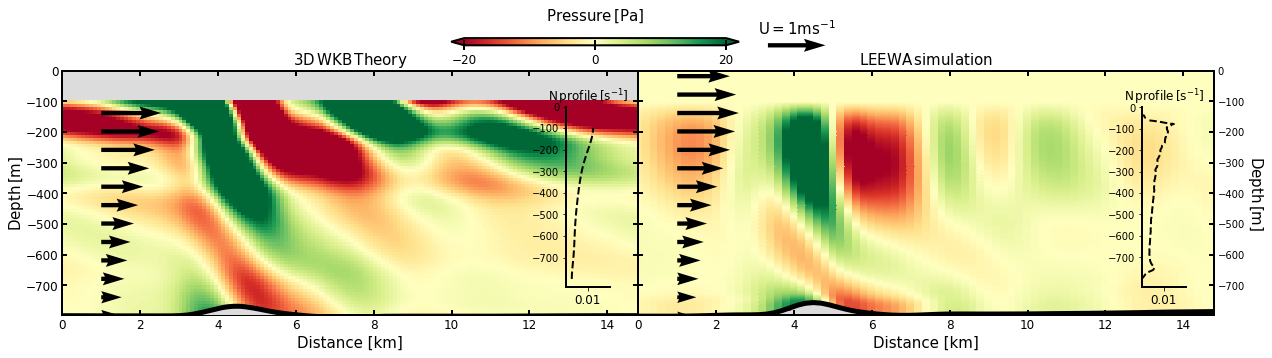

In [19]:
#pour tracer des profils de vitesse sur les plots
prof_U_tmp=np.nanmean(U[step_file,:,:],axis=1)
prof_bvf2_tmp=np.nanmean(bvf2[step_file,:,:],axis=1)
prof_bvf_tmp=np.sqrt(prof_bvf2_tmp)

from scipy import interpolate

plt.rcParams['axes.facecolor'] = 'gainsboro'

N_sub=2

fig=plt.figure(figsize=(N_sub*10,5))


minp=-20
maxp=20




for i in range(N_sub):
    ax=plt.subplot(1,N_sub,i+1)

    
    if i==1:

        plt.title(r'${\rm LEEWA\, simulation}$',fontsize=15)

        #### WHAT we plot#####
        #x_tmp=x-8
        pc=plt.pcolormesh(x_dec,z,P_mean[:,:],cmap='RdYlGn',vmin=minp,vmax=maxp)
        
              
        #prof of velocity
        f = interpolate.interp1d(z_reg[:,0], prof_U_tmp)
        prof_z=np.arange(np.min(z_reg[:,0]),np.max(z_reg[:,0]),10)
        prof_U=f(prof_z)
        nshow=int(len(prof_U)/12)
        Q=plt.quiver(1*np.ones(prof_z[::nshow].shape),prof_z[::nshow],
                     prof_U[::nshow],np.zeros(prof_z[::nshow].shape),scale=10)
        #lines
        plt.plot(x_dec[:],-h[:],'-k',linewidth=5)
        #plt.plot(x[0,:],z_bml_all[step_file],'--',label='BML',linewidth=2,color='gray')
        
        
        ######################
        plt.axis([np.min(xx_v[0,:]),np.max(xx_v[0,:]),np.min(z[:,:]),np.max(z[:,:])])
        plt.xlabel('Distance [km]',fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(np.arange(0,-800,-100),fontsize=0.01)
        plt.ylabel(r'${\rm Depth\, [m]}$',fontsize=15,labelpad=20,rotation=-90)
        ax.yaxis.set_label_position("right")
        ax.yaxis.set_ticks_position("right")
        ax.spines['left'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)       
        ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)   

        
        
        
        plt.rcParams['axes.facecolor'] = (1,1,1,0)
        prof_ax=fig.add_axes([0.85, 0.2, 0.03, 0.5])
        plt.title(r'${\rm N\,profile \,[s^{-1}]}$')
        plt.plot(prof_bvf_tmp,z_reg[:,0],'--k',linewidth=2)
        plt.xticks([1.e-2],fontsize=12)
        plt.yticks(np.arange(0,-800,-100))
        #prof_ax.tick_params(labelleft='off') 
        prof_ax.set_xlim(0,2.e-2)
        #prof_ax.set_ylim(np.min(z_prof),0)
        prof_ax.spines['top'].set_linewidth(0)
        prof_ax.spines['left'].set_linewidth(2)
        prof_ax.spines['bottom'].set_linewidth(2)
        prof_ax.spines['right'].set_linewidth(0)
        #plt.grid(linewidth=2)
        plt.rcParams['axes.facecolor'] = 'gainsboro'

    
    
    
    elif i==0:
        plt.title(r'${\rm 3D\,WKB\,Theory}$',fontsize=15)
    
    
        #### WHAT we plot#####
        pc=plt.pcolor(xx_v,zz_v,P_hydro_th[:,idx_sect+1,:],cmap='RdYlGn',vmin=minp,vmax=maxp)

        plt.plot(x_th,h_th[idx_sect+1,:],'-k',linewidth=5,zorder=11)
        plt.fill(x_th,h_th[idx_sect+1,:]-1,'-k',facecolor='gainsboro',linewidth=5,zorder=10)
        nshow2=int(len(prof_U_th)/11)
        Q=plt.quiver(1*np.ones(z_th[::nshow2].shape),z_th[::nshow2],
                     prof_U_th[::nshow2],np.zeros(z_th[::nshow2].shape),scale=10)
        #Q=plt.quiver(1*np.ones(z_th[::nshow2].shape),z_th[::nshow2],
        #             np.nanmean(prof_U_th)*np.ones(prof_U_th[::nshow2].shape),np.zeros(z_th[::nshow2].shape),scale=10)
    
        ######################
        plt.axis([np.min(xx_v[0,:]),np.max(xx_v[0,:]),np.min(z[:,:]),np.max(z[:,:])])
        plt.xlabel('Distance [km]',fontsize=15)
        plt.xticks(fontsize=12)
        plt.ylabel(r'${\rm Depth\, [m]}$',fontsize=15,labelpad=0,rotation=90)
        plt.yticks(np.arange(0,-800,-100),fontsize=12)
        ax.spines['left'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)       
        ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)  
    
    
    
        plt.rcParams['axes.facecolor'] = (1,1,1,0)
    
        prof_ax=fig.add_axes([0.45, 0.2, 0.03, 0.5])
        plt.title(r'${\rm N\, profile\,[s^{-1}]}$')
        plt.plot(prof_bvf_th,z_th,'--k',linewidth=2)
        #plt.plot(np.nanmean(prof_bvf_th)*np.ones(prof_bvf_th.shape),z_th,'--k',linewidth=2)
        plt.xticks([1.e-2],fontsize=12)
        plt.yticks(np.arange(0,-800,-100))
        #prof_ax.tick_params(labelleft='off') 
        prof_ax.set_xlim(0,2.e-2)
        #prof_ax.set_ylim(np.min(z_prof),0)
        prof_ax.spines['top'].set_linewidth(0)
        prof_ax.spines['left'].set_linewidth(2)
        prof_ax.spines['bottom'].set_linewidth(2)
        prof_ax.spines['right'].set_linewidth(0)    
        #plt.grid(linewidth=2)
        plt.rcParams['axes.facecolor'] = 'gainsboro'
        
 
    
    
    

    
    

    
qk=ax.quiverkey(Q, X=0.61, Y=0.87, U=1,
             label=r'${\rm U=1ms^{-1}}$',fontproperties={'size':15}, labelpos='N',coordinates='figure')
#t = qk.text.set_backgroundcolor('g')
    
cbar_ax = fig.add_axes([0.37, 0.87, 0.2, 0.02])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=[minp,0,maxp])
cbar.set_label(r"${\rm Pressure \,[Pa]}$", fontsize=15, 	rotation=0,labelpad=-60)
#cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(labelsize=12,direction='inout',width=2,length=10)
    
    

plt.subplots_adjust(left=0.1,bottom=0.12,right=0.9,top=0.8,wspace=0.0)  

plt.savefig(pathsave_figs+'/compare_P_3Dc_LEEWA.png',dpi=200)

plt.show()

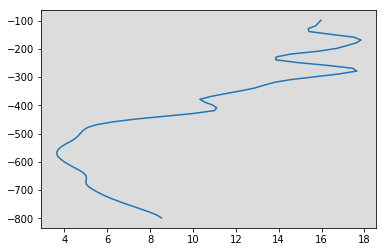

In [21]:
#theoretical profile of FmZ from theory
FmZ_hydro_th=rho0*np.sqrt((w_hydro_th*u_hydro_th)**2 + (w_hydro_th*v_hydro_th)**2)
prof_FmZ_th=np.nansum(FmZ_hydro_th[:,idx_sect+1,:],axis=1)
#plt.pcolormesh(xx_v,zz_v,FmZ_hydro_th[:,idx_sect+1,:],cmap='jet',vmin=minp,vmax=maxp)
plt.plot(prof_FmZ_th,z_th)
plt.show()

# II- From 3D field
## Compare w : top view

In [18]:
depth=-500
step_file=372

In [19]:
#get field from simulation and interpolate it on a z-level

### LOAD SIMULATION

In [20]:
#load parameters of the simulation
h,lon,lat,mask,f,time_ini,pm,pn,angle=load_param_simulation(path1)


#for idealized seamount
cl1=600 #bas
cl2=800
cl3=230 #gauche
cl4=400
'''
#for section over the bump
lonsec=[-78.4,-78.07]
latsec=[31.53,31.77]
cl1=1200 #bas
cl2=1480
cl3=450 #gauche
cl4=550
'''

lon=lon[cl1:cl2,cl3:cl4]
lat=lat[cl1:cl2,cl3:cl4]
h=h[cl1:cl2,cl3:cl4]

('date du fichier ini:', datetime.date(2016, 3, 20))


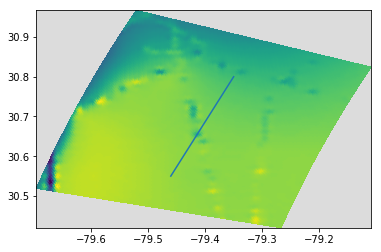

In [21]:
plt.pcolormesh(lon,lat,h)
plt.plot(lonsec,latsec)

### load all for filtering

In [22]:



nsave=6 #take every ___ hours
ind_file_ini=0 
step_tot=0
N_files=24
N_steps=24


st=int(N_files*(N_steps/nsave))
sx=len(lon[0,:])
sy=len(lat[:,0])
w=  np.zeros((st,sy,sx))

for i in range (N_files):   
    ind_file=i*N_steps+ind_file_ini
    if ind_file<10:
        file='/leewa_avg.0000{}.nc'.format(ind_file)
    elif ind_file<100:
        file='/leewa_avg.000{}.nc'.format(ind_file)
    else :
        file='/leewa_avg.00{}.nc'.format(ind_file)
    print('loading file ',file)

    for j in range(0,N_steps,nsave):
        print('h ',j)
        
        step_tot=step_tot+1
        time_step=ind_file+j
 
            
        ncfile=path2+file
        nc = Dataset(ncfile)
        rho0=getattr(nc,'rho0')
        hc=getattr(nc,'hc')
        Cs_r=getattr(nc,'Cs_r')
        Cs_w=getattr(nc,'Cs_w')
            

        if step_tot==1:
            zeta_t= nc.variables['zeta'][j,cl1:cl2,cl3:cl4]
            z_r,z_w=zlevs(h,zeta_t, hc, Cs_r, Cs_w)
        w_t= nc.variables['w'][j,:,cl1:cl2,cl3:cl4]
        g=9.81
        s_rho=w_t.shape[0]
        nc.close()
        
        #to take at a specific depth
        w_interp=vinterp(w_t[:,:,:],z_r,depth,h,0)
        
        
        w[step_tot-1]=  w_interp
       
        zeta_t= []
        w_t= []
        rho_t= []
        u_t=[]
        v_t=[]
        

('loading file ', '/leewa_avg.00000.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00024.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00048.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00072.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00096.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00120.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00144.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00168.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00192.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00216.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00240.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('loading file ', '/leewa_avg.00264.nc')
('h ', 0)
('h ', 6)
('h ', 12)
('h ', 18)
('lo

### filtering

In [23]:
from scipy import signal
order=4
T_cut=4*24 ##### periode de filtrage : a evaluer en fonction du temps de changement du champ
freq_cut=1./T_cut
dt=nsave ##### le temps entre chaque fichier, normalement 1h
freq_ech=1./dt
wn=freq_cut/(freq_ech/2.)
b, a = signal.butter(order, wn,btype='lowpass')

In [24]:
w_filt= signal.filtfilt(b, a, w,axis=0)

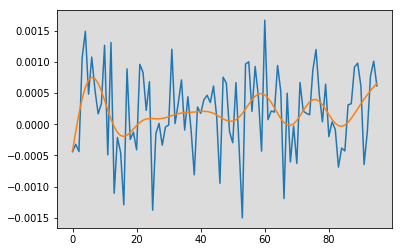

In [25]:
plt.plot(w[:,50,50])
plt.plot(w_filt[:,50,50])

In [26]:
#load a few parameters from simulation output

ind_file=step_file-step_file%24

file='/leewa_avg.00{}.nc'.format(ind_file)

step=step_file%24
ncfile=path2+file
nc = Dataset(ncfile)
rho0=getattr(nc,'rho0')
hc=getattr(nc,'hc')
Cs_r=getattr(nc,'Cs_r')
Cs_w=getattr(nc,'Cs_w')
g=9.81

u= nc.variables['u'][step,:,cl1:cl2,cl3:cl4]
v= nc.variables['v'][step,:,cl1:cl2,cl3:cl4]
#u=0.5*(u_tmp[:,1:,:]+u_tmp[:,0:-1,:])
#v=0.5*(v_tmp[:,:,1:]+v_tmp[:,:,0:-1])
#u_tmp=[]
#v_tmp=[]

nc.close()

u,v=rotate_uv(u,v,angle[cl1:cl2,cl3:cl4])

u_interp=vinterp(u,z_r,depth,h,0)
v_interp=vinterp(v,z_r,depth,h,0)

print('load from ',ncfile)



#and from section just for axis



#file='/sections_4_5.nc'
#file='/sections.nc'
#file='/sections_all.nc'
file='/sections_filtered.nc'
ncfile=pathsave_sect+file

nc = Dataset(ncfile)
print(nc.variables.keys())
x_sec= nc.variables['x'][:]
z_sec= nc.variables['z'][:]
h_sec= nc.variables['h'][:]
nc.close()



('load from ', '/home2/scratch/cdemarez/LEEWA/finalv2/leewa_avg.00360.nc')
[u'x', u'z', u'h', u'f', u'hbbl', u'w', u'rho', u'u', u'v', u'bvf2', u'AKv', u'AKt']


In [27]:
#nc = Dataset('./theory_3D_section_{}_{}_{}_{}.nc'.format(lonsec[0],lonsec[1],latsec[0],latsec[1]))
#nc = Dataset('./theory_3D_section_{}_{}_{}_{}_radi.nc'.format(lonsec[0],lonsec[1],latsec[0],latsec[1]))
#nc = Dataset('./theory_3D_section_{}_{}_{}_{}_roof.nc'.format(lonsec[0],lonsec[1],latsec[0],latsec[1]))
nc = Dataset('./theory_3D_section_{}_{}_{}_{}_radinf_WKBJ_little.nc'.format(lonsec[0],lonsec[1],latsec[0],latsec[1]))
print(nc.variables.keys())
x_th=nc.variables['x'][:]/1000
y_th=nc.variables['y'][:]/1000
z_th=nc.variables['z'][:]
h_th=nc.variables['topo'][:]
w_hydro_th=nc.variables['w'][:]
u_hydro_th=nc.variables['u'][:]
v_hydro_th=nc.variables['v'][:]
P_hydro_th=nc.variables['P'][:]
rho_hydro_th=nc.variables['rho'][:]



prof_U_th=nc.variables['U_prof'][:]
prof_Uzz_th=nc.variables['Uzz_prof'][:]
prof_bvf_th=nc.variables['bvf_prof'][:]
idx_sect=int(nc.variables['idx_section'][0])  ##just to know where is the section

nc.close()
h_th=h_th-np.abs(np.min(z))
#x_th=x_th+x[0,np.argmax(-h)]
z_th=z_th-np.abs(np.min(z))

#for sections
xx_v,zz_v=np.meshgrid(x_th,z_th) 
xx_h,yy_h=np.meshgrid(x_th,y_th) 

[u'x', u'y', u'z', u'topo', u'U_prof', u'Uzz_prof', u'bvf_prof', u'idx_section', u'w', u'u', u'v', u'P', u'rho', u'Divergence', u'Strain']


In [28]:
#the step we want top plot to compare with theory
w_plot=w_filt[step_file//nsave,:,:]

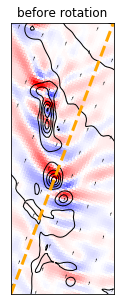

In [29]:
fig=plt.figure(figsize=(5,5))
ax=plt.subplot(111,aspect='equal')


minp=-0.01
maxp=0.01

ax.set_title(r'before rotation')

eps_lat=0.0
eps_lon=0#0.1
corners=[np.min(lonsec)-eps_lon,np.min(latsec)-eps_lat,np.max(lonsec)+eps_lon,np.max(latsec)+eps_lat]
map = Basemap(llcrnrlon=corners[0],llcrnrlat=corners[1],urcrnrlon=corners[2],urcrnrlat=corners[3],resolution='i',projection='merc')


#date_tmp=print_date(time)

xx, yy = map(lon, lat)




pc=map.pcolormesh(xx,yy,w_plot,vmin=minp,vmax=maxp,cmap='bwr')
CS=map.contour(xx,yy,h,np.arange(0,1000,10),colors='k',linewidths=1)

nshow=10
lev_u=-30

Q=map.quiver(xx[::nshow,::nshow],yy[::nshow,::nshow],
           u_interp[::nshow,::nshow],v_interp[::nshow,::nshow],pivot='mid',color='k',width=0.004,scale=1./0.08)
#plt.clabel(CS, inline=1, fontsize=10,colors='k')
xll, yll = map(lonsec, latsec)

map.plot(xll, yll, '--', linewidth=3,color='orange') 
plt.show()


xll=xll+np.abs(np.min(xx))
yll=yll+np.abs(np.min(yy))
xx=xx+np.abs(np.min(xx))
yy=yy+np.abs(np.min(yy))#just to start at zero


### Rotate the leewa output to compare it with theory
# take the same zone than in the theory calculation !!

In [30]:
#first interpolation (to prepare rotation)
dx=100
dy=100


xnew=np.arange(np.min(xx),np.max(xx),dx)
ynew=np.arange(np.min(yy),np.max(yy),dy)
xx_new,yy_new=np.meshgrid(xnew,ynew)

## interpolate on a regular grid
w_new= griddata((np.ravel(xx), np.ravel(yy)), np.ravel(np.nan_to_num(w_plot)), (xx_new, yy_new), method='cubic')
h_new= griddata((np.ravel(xx), np.ravel(yy)), np.ravel(h), (xx_new, yy_new), method='cubic')
u_new= griddata((np.ravel(xx), np.ravel(yy)), np.ravel(u_interp), (xx_new, yy_new), method='cubic')
v_new= griddata((np.ravel(xx), np.ravel(yy)), np.ravel(v_interp), (xx_new, yy_new), method='cubic')

In [31]:
#####
#rotate the grid
#####
#find angle of section
tmpx=xll[1]-xll[0]
tmpy=yll[1]-yll[0]
angle=np.arctan2(tmpy,tmpx)
angle=np.rad2deg(angle)

from scipy.ndimage.interpolation import rotate
xx_rot_tmp=rotate((xx_new),-angle,axes=(0,1))
yy_rot_tmp=rotate((yy_new),-angle,axes=(0,1))
angle_rr=np.pi/2-np.deg2rad(angle)
xx_grd_rot=xx_rot_tmp*np.sin(angle_rr)+yy_rot_tmp*np.cos(angle_rr)
yy_grd_rot=xx_rot_tmp*np.cos(angle_rr)-yy_rot_tmp*np.sin(angle_rr)
#rotate the fields
w_rot=rotate(np.nan_to_num(w_new),-angle,axes=(0,1))
h_rot=rotate(np.nan_to_num(h_new),-angle,axes=(0,1))
u_rot=rotate(np.nan_to_num(u_new),-angle,axes=(0,1))
v_rot=rotate(np.nan_to_num(v_new),-angle,axes=(0,1))

#just eof the position of the section
xll_rot=np.array(xll)*np.sin(angle_rr)+np.array(yll)*np.cos(angle_rr)
yll_rot=np.array(xll)*np.cos(angle_rr)-np.array(yll)*np.sin(angle_rr)

In [32]:
#####
#take only one region of rotated plot 
#####
def take_zone(field):
    
    
    #seamount
    cx1=35*1000
    cx2=50*1000
    cy1=12*1000
    cy2=23*1000
    


    '''
    #on the bump
    cx1=15*1000
    cx2=78*1000
    cy1=-12*1000
    cy2=2*1000
    '''
    
    
    tmp1=xx_grd_rot>cx1
    tmp2=xx_grd_rot<cx2
    tmp3=yy_grd_rot>cy1
    tmp4=yy_grd_rot<cy2
    TMP=tmp1&tmp2&tmp3&tmp4
    return field[TMP]

#print(h_rot.shape)


xx_z=take_zone(xx_grd_rot)
yy_z=take_zone(yy_grd_rot)
w_z=take_zone(w_rot)
h_z=take_zone(h_rot)
u_z=take_zone(u_rot)
v_z=take_zone(v_rot)

DX=200 #the resolution for the final fields : define the resolution for the theoretical resolution
DY=200
x_f=np.arange(np.min(xx_z),np.max(xx_z),DX)
y_f=np.arange(np.min(yy_z),np.max(yy_z),DY)
xx_f,yy_f=np.meshgrid(x_f,y_f)

w_final= griddata((xx_z, yy_z),w_z, (xx_f, yy_f), method='cubic')
h_final= griddata((xx_z, yy_z),h_z, (xx_f, yy_f), method='cubic')
u_final= griddata((xx_z, yy_z),u_z, (xx_f, yy_f), method='cubic')
v_final= griddata((xx_z, yy_z),v_z, (xx_f, yy_f), method='cubic')
u_final,v_final=rotate_uv(u_final,v_final,-angle)


xx_final=xx_f-np.min(xx_f)
yy_final=yy_f-np.min(yy_f)
xll_final=xll_rot-np.min(xx_f)
yll_final=yll_rot-np.min(yy_f)

xx_final=xx_final/1000
yy_final=yy_final/1000
xll_final=xll_final/1000
yll_final=yll_final/1000

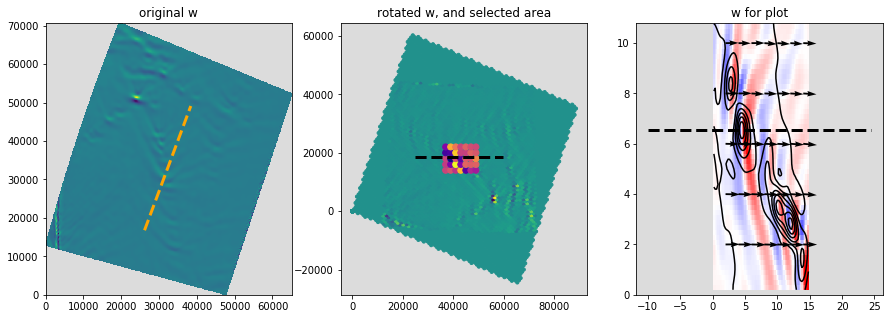

In [33]:
plt.figure(figsize=(15,5))
ax1=plt.subplot(131)
plt.title('original w')
plt.pcolormesh(xx_new,yy_new,w_new)
plt.plot(xll, yll, '--', linewidth=3,color='orange') 
ax1=plt.subplot(132)
plt.title('rotated w, and selected area')
n=10
plt.scatter((xx_grd_rot[::n,::n]),(yy_grd_rot[::n,::n]),c=(w_rot[::n,::n]),s=10)
plt.scatter((xx_f[::n,::n]),(yy_f[::n,::n]),c=(w_final[::n,::n]),cmap='plasma')
plt.plot(xll_rot, yll_rot, '--', linewidth=3,color='k') 
ax1=plt.subplot(133)
plt.title('w for plot')
plt.pcolormesh((xx_final),(yy_final),(w_final),cmap='bwr',vmin=-0.01,vmax=0.01)
plt.contour((xx_final),(yy_final),(h_final),colors='k')
nshow=10
plt.quiver(xx_final[::nshow,::nshow],yy_final[::nshow,::nshow],
          u_final[::nshow,::nshow],v_final[::nshow,::nshow])

plt.plot(xll_final, yll_final, '--', linewidth=3,color='k')
plt.show()

('z=', -497.24707)


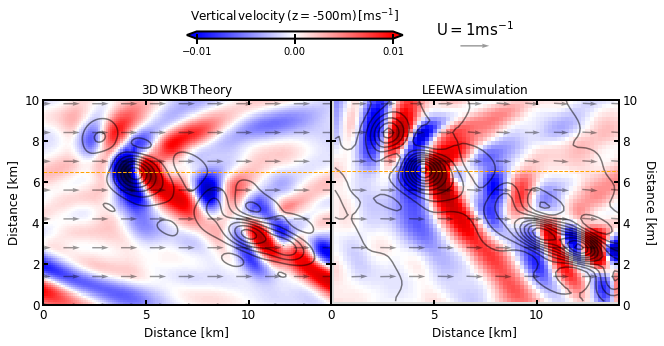

In [34]:
import matplotlib
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


val_cont=np.arange(-805,-700,5)
#val_cont=np.arange(-700,-500,10)


id_tmp,=np.where(z_th>depth)
idx_cut=id_tmp[0]
print ('z=',z_th[idx_cut])


u_th=np.ones(xx_h.shape)*prof_U_th[idx_cut]
v_th=np.ones(yy_h.shape)*0


minp=-0.01
maxp=0.01

#ideali seamount
limx=14
limy=10
#on the bump
#limx=60
#limy=12


fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(121,aspect='equal')

plt.title(r'${\rm 3D \,WKB\, Theory}$')


ax1.pcolormesh(xx_h[:,:],yy_h[:,:],w_hydro_th[idx_cut,:,:],vmin=minp,vmax=maxp,cmap='seismic')
ax1.contour(xx_h[:,:],yy_h[:,:],h_th[:,:],val_cont,colors='k',alpha=0.5)

nshow=len(xx_h[0,:])//10
Q=plt.quiver(xx_h[::nshow,::nshow],yy_h[::nshow,::nshow],
          u_th[::nshow,::nshow],v_th[::nshow,::nshow],scale=1./0.1,pivot='mid',width=0.005,zorder=15,alpha=0.4)

yll_theory=np.array([y_th[idx_sect+1],y_th[idx_sect+1]])
xll_theory=np.array([0,np.max(x_th)])
ax1.plot(xll_theory, yll_theory, '--', linewidth=1,color='orange')






ax1.set_xlim(0,limx)
ax1.set_ylim(0,limy)

plt.yticks(fontsize=12)
plt.xticks(np.arange(0,limx,5),fontsize=12)
plt.xlabel('Distance [km]',fontsize=12)
plt.ylabel('Distance [km]',fontsize=12)

ax1.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1) 

ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_linewidth(2)
ax1.spines['right'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)



ax2=plt.subplot(122,aspect='equal')

plt.title(r'${\rm LEEWA \, simulation}$')

ax2.pcolormesh((xx_final),(yy_final),(w_final),cmap='seismic',vmin=minp,vmax=maxp)
ax2.contour((xx_final),(yy_final),(-h_final),val_cont,colors='k',alpha=0.5)
nshow=len(xx_final[0,:])//10
ax2.quiver(xx_final[::nshow,::nshow],yy_final[::nshow,::nshow],
          u_final[::nshow,::nshow],v_final[::nshow,::nshow],scale=1./0.1,pivot='mid',width=0.005,zorder=15,alpha=0.4)

ax2.plot(xll_final, yll_final, '--', linewidth=1,color='orange')

ax2.set_xlim(0,limx)
ax2.set_ylim(0,limy)


ax2.tick_params(labelleft='off') 
ax2.tick_params(labelright='on') 
plt.yticks(fontsize=12)
plt.xticks(np.arange(0,limx,5),fontsize=12)
plt.xlabel('Distance [km]',fontsize=12)
plt.ylabel('Distance [km]',fontsize=12,rotation=-90,labelpad=20)
ax2.yaxis.set_label_position("right")

ax2.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1) 

ax2.spines['top'].set_linewidth(2)
ax2.spines['left'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)

plt.subplots_adjust(left=0.1,bottom=0.12,right=0.9,top=0.79,wspace=0.0) 



qk=ax2.quiverkey(Q, X=0.7, Y=0.89, U=1,
             label=r'${\rm U=1ms^{-1}}$',fontproperties={'size':15}, labelpos='N',coordinates='figure')


cbar_ax = fig.add_axes([0.3, 0.91, 0.3, 0.02])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=[minp,0,maxp])
#cbar.set_label(r"${\rmDensisty \,[ kg.m^{-3}]}$", fontsize=15, 	rotation=0,labelpad=-55)
cbar.set_label(r"${\rm Vertical\, velocity\,(z=}$"+'{}'.format(depth)+r"${\rm m) \,[ ms^{-1}]}$",
               fontsize=12, 	rotation=0,labelpad=-50)
#cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(labelsize=10,direction='inout',width=2,length=10)

  



#plt.savefig(pathsave_figs+'/compare_w_h_3Dc_LEEWA.png',dpi=200)


plt.show()

In [35]:
## save the value to make the final fancy plot

x_h_th=xx_h
y_h_th=yy_h
w_h_th=w_hydro_th[idx_cut,:,:]
h_h_th=h_th[:,:]
u_h_th=u_th
v_h_th=v_th
xll_th=xll_theory
yll_th=yll_theory

x_h_leewa=xx_final
y_h_leewa=yy_final
w_h_leewa=w_final
h_h_leewa=h_final
u_h_leewa=u_final
v_h_leewa=v_final
xll_leewa=xll_final
yll_leewa=yll_final


# Fancy plot for paper

In [ ]:
'''
x_bot_leewa=x_dec
w_bot_leewa=w_bottom
P_bot_leewa=P_bottom
FeZ_bot_leewa=FeZ_bottom
h_bot_leewa=-h-np.min(-h)

x_bot_th=x_th
w_bot_th=w_hydro_th[0,idx_sect+1,:]
P_bot_th=P_hydro_th[0,idx_sect+1,:]
FeZ_bot_th=FeZ_hydro_th[0,idx_sect+1,:]
h_bot_th=h_th[idx_sect+1,:]-np.median(h_th[idx_sect+1,:])
'''

In [ ]:
'''###Save the section value to plot after on the big fancy plot

x_sect_leewa=x_tmp
z_sect_leewa=z
w_sect_leewa=w[step_file,:,:]
prof_U_sect_leewa=prof_U_tmp
prof_bvf_sect_leewa=prof_bvf_tmp #plot it against z_sect_leewa[:,0]
h_sect_leewa=h

x_sect_th=x_th-decx
z_sect_th=zz_v
w_sect_th=w_hydro_th[:,idx_sect+1,:]
prof_U_sect_th=prof_U_th
prof_bvf_sect_th=prof_bvf_th
h_sect_th=h_th[idx_sect+1,:]'''

saving
showing


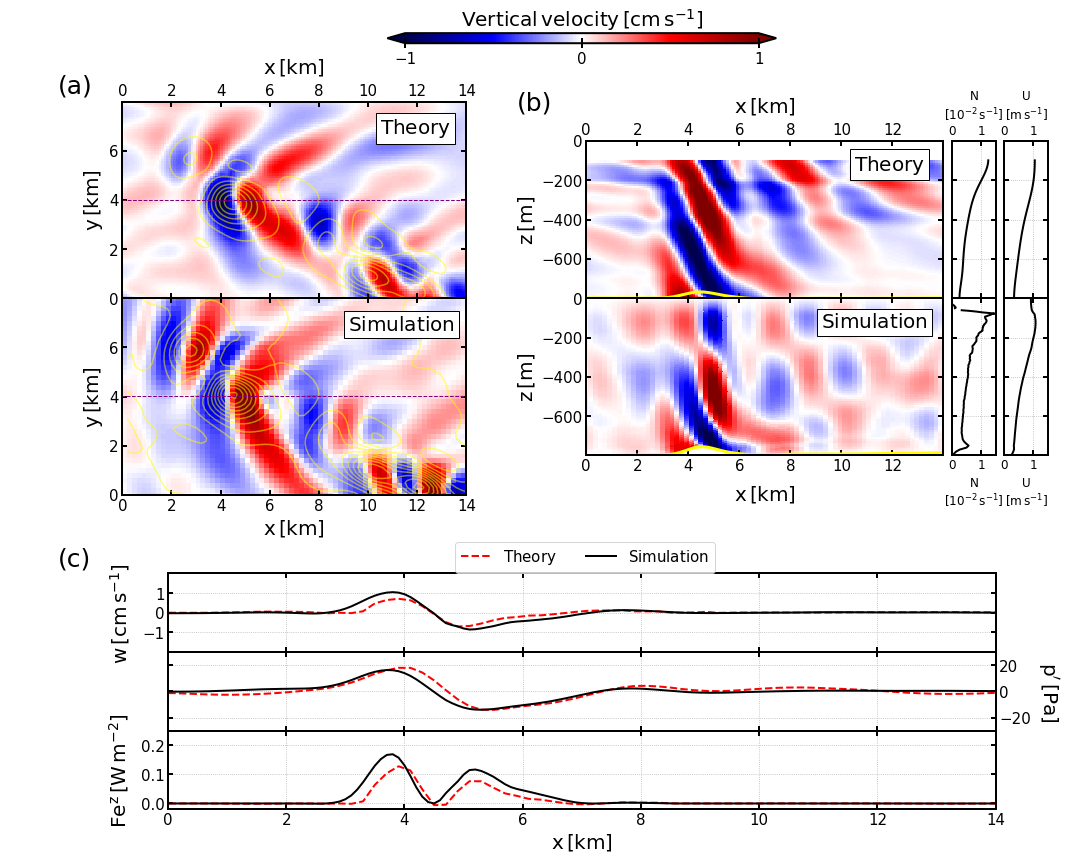

In [60]:
from matplotlib import gridspec
plt.rcParams['axes.facecolor'] = 'w'
import matplotlib.patches as patches
import matplotlib as matplotlib

minplw=-1
maxplw=1
val_cont=np.arange(-805,-700,5)

fig=plt.figure(figsize=(18,14))
gs = gridspec.GridSpec(20, 20) 
gs.update(bottom=0.12,top=0.9,left=0.1, right=0.9, hspace=0.00)

decy_h=2.5
limx=14
limz1=-800
limz2=0
limN=1.5
limU=1.5


########
#H view#
#########


ax=plt.subplot(gs[2:7, 1:8],aspect='equal')
pc=plt.pcolormesh(x_h_th,y_h_th-decy_h,w_h_th*100,cmap='seismic',vmin=minplw,vmax=maxplw,rasterized=True)
plt.contour(x_h_th,y_h_th-decy_h,h_h_th,val_cont,colors='yellow',alpha=0.5,rasterized=True)

plt.plot(xll_th, yll_th-decy_h, '--', linewidth=1,color='purple')

ax.set_ylim(0,8)
ax.set_xlim(0,limx)

ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")

plt.ylabel(r"${\rm y\, [km]}$",fontsize=20)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=20,labelpad=10)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,8,2),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)

t=ax.annotate(r'${\rm Theory}$', xy=(10.5,6.7),  xycoords='data',
                color='k',size=20,zorder=30
                )
t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='k'))

ax=plt.subplot(gs[7:12, 1:8],aspect='equal')
plt.pcolormesh(x_h_leewa-0.2,y_h_leewa-decy_h,w_h_leewa*100,cmap='seismic',vmin=minplw,vmax=maxplw,rasterized=True)
plt.contour(x_h_leewa,y_h_leewa-decy_h,-h_h_leewa,val_cont,colors='yellow',alpha=0.5,rasterized=True)

plt.plot(xll_leewa, yll_leewa-decy_h, '--', linewidth=1,color='purple')


ax.set_ylim(0,8)
ax.set_xlim(0,limx)

plt.ylabel(r"${\rm y\, [km]}$",fontsize=20)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=20)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,8,2),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)

t=ax.annotate(r'${\rm Simulation}$', xy=(9.2,6.7),  xycoords='data',
                color='k',size=20,zorder=30
                )
t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='k'))

##########
#SIDE VIEW
##########

ax=plt.subplot(gs[3:7, 10:17])
plt.pcolormesh(x_sect_th,z_sect_th,w_sect_th*100,cmap='seismic',vmin=minplw,vmax=maxplw,rasterized=True)
plt.plot(x_sect_th,h_sect_th,'-',color='yellow',linewidth=3)
ax.set_ylim(limz1,limz2)
ax.set_xlim(0,limx)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
plt.ylabel(r"${\rm z\, [m]}$",fontsize=20)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=20,labelpad=10)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(np.arange(0,14,2),fontsize=15)
plt.yticks(np.arange(limz1+200,limz2+200,200),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)

t=ax.annotate(r'${\rm Theory}$', xy=(10.5,-150),  xycoords='data',
                color='k',size=20,zorder=30
                )
t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='k'))

ax=plt.subplot(gs[3:7, 17:18])
plt.plot(prof_bvf_sect_th*100,z_sect_th[:,0],'-k',linewidth=2)
ax.set_ylim(limz1,limz2)
ax.set_xlim(0,limN)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
#plt.ylabel(r"${\rm z\, [m]}$",fontsize=20)
#plt.xlabel(r'${\rm x\, [km]}$',fontsize=20,labelpad=10)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)   
#ax2.spines['top'].set_position(['outward',20])
plt.xticks([0,1],fontsize=12)
plt.yticks(np.arange(limz1+200,limz2+200,200),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.xlabel(r'${\rm N}$'
           '\n'
           r'${\rm [10^{-2}\,s^{-1}]}$',fontsize=12,rotation=0,labelpad=5)
plt.grid(linestyle=':')
ax=plt.subplot(gs[3:7, 18:19])
plt.plot(prof_U_sect_th,z_sect_th[:,0],'-k',linewidth=2)
ax.set_ylim(limz1,limz2)
ax.set_xlim(0,limU)
#ax.yaxis.set_label_position("top")
#ax.yaxis.set_ticks_position("")
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
#plt.ylabel(r"${\rm z\, [m]}$",fontsize=20)
plt.xlabel(r'${\rm U}$'
           '\n'
           r'${\rm [m\,s^{-1}]}$',fontsize=12,rotation=0,labelpad=5)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)   
#ax2.spines['top'].set_position(['outward',20])
plt.xticks([0,1],fontsize=12)
plt.yticks(np.arange(limz1+200,limz2+200,200),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.grid(linestyle=':')





ax=plt.subplot(gs[7:11, 10:17])
plt.pcolormesh(x_sect_leewa,z_sect_leewa,w_sect_leewa*100,cmap='seismic',vmin=minplw,vmax=maxplw,rasterized=True)
plt.plot(x_sect_leewa[0,:],-h_sect_leewa,'-',color='yellow',linewidth=3)
ax.set_ylim(limz1,limz2)
ax.set_xlim(0,limx)
plt.ylabel(r"${\rm z\, [m]}$",fontsize=20)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=20,labelpad=10)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(np.arange(0,14,2),fontsize=15)
plt.yticks(np.arange(limz1+200,limz2+200,200),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)

t=ax.annotate(r'${\rm Simulation}$', xy=(9.2,-150),  xycoords='data',
                color='k',size=20,zorder=30
                )
t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='k'))

ax=plt.subplot(gs[7:11, 17:18])
plt.plot(prof_bvf_sect_leewa*100,z_sect_leewa[:,0],'-k',linewidth=2)
ax.set_ylim(limz1,limz2)
ax.set_xlim(0,limN)
ax.yaxis.set_major_formatter(plt.NullFormatter())
#plt.ylabel(r"${\rm z\, [m]}$",fontsize=20)
#plt.xlabel(r'${\rm x\, [km]}$',fontsize=20,labelpad=10)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)   
#ax2.spines['top'].set_position(['outward',20])
plt.xticks([0,1],fontsize=12)
plt.yticks(np.arange(limz1+200,limz2+200,200),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.xlabel(r'${\rm N}$'
           '\n'
           r'${\rm [10^{-2}\,s^{-1}]}$',fontsize=12,rotation=0,labelpad=5)
plt.grid(linestyle=':')
ax=plt.subplot(gs[7:11, 18:19])
plt.plot(prof_U_sect_leewa,z_sect_leewa[:,0],'-k',linewidth=2)
ax.set_ylim(limz1,limz2)
ax.set_xlim(0,limU)
#ax.yaxis.set_label_position("top")
#ax.yaxis.set_ticks_position("")
ax.yaxis.set_major_formatter(plt.NullFormatter())
#plt.ylabel(r"${\rm z\, [m]}$",fontsize=20)
plt.xlabel(r'${\rm U}$'
           '\n'
           r'${\rm [m\,s^{-1}]}$',fontsize=12,rotation=0,labelpad=5)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)   
#ax2.spines['top'].set_position(['outward',20])
plt.xticks([0,1],fontsize=12)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.grid(linestyle=':')





##########
##Compare bot
##########

ax=plt.subplot(gs[14:16, 2:18])
plt.plot(x_bot_leewa,w_bot_leewa*1.e2,'--r',linewidth=2,label=r'${\rm Theory}$')
plt.plot(x_bot_th,w_bot_th*1.e2,'-k',linewidth=2,label=r'${\rm Simulation}$')
plt.ylabel(r'${\rm w\, [cm\,s^{-1}]}$',fontsize=20,rotation=90,labelpad=10)
#plt.xlabel(r'${\rm x\, [km]}$',fontsize=20)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(-2,2)
ax.set_xlim(0,limx)
#ax.yaxis.set_label_position("right")
#ax.yaxis.set_ticks_position("right")
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(fontsize=15)
plt.yticks(np.arange(-1,2,1),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.legend(facecolor='white',fontsize=15,ncol=2,bbox_to_anchor=(0.67,1.5))
plt.grid(linestyle=':')

ax=plt.subplot(gs[16:18, 2:18])
plt.plot(x_bot_leewa,P_bot_leewa,'--r',linewidth=2,label=r'${\rm 3D \,Theory}$')
plt.plot(x_bot_th,P_bot_th,'-k',linewidth=2,label=r'${\rm Realistic\, simulation}$')
plt.ylabel(r"${\rm p'\, [Pa]}$",fontsize=20,rotation=-90,labelpad=30)
#plt.xlabel(r'${\rm x\, [km]}$',fontsize=20)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(-30,30)
ax.set_xlim(0,limx)
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position("right")
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(fontsize=15)
plt.yticks(np.arange(-20,30,20),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.grid(linestyle=':')

ax=plt.subplot(gs[18:20, 2:18])
plt.plot(x_bot_leewa,FeZ_bot_leewa,'--r',linewidth=2,label=r'${\rm 3D \,Theory}$')
plt.plot(x_bot_th,FeZ_bot_th,'-k',linewidth=2,label=r'${\rm Realistic\, simulation}$')
plt.ylabel(r'${\rm Fe^z\, [W\,m^{-2}]}$',fontsize=20,rotation=90,labelpad=10)
plt.xlabel(r'${\rm x\, [km]}$',fontsize=20)
ax.set_ylim(-0.02,0.25)
ax.set_xlim(0,limx)
#ax.yaxis.set_label_position("right")
#ax.yaxis.set_ticks_position("right")
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)       
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,0.3,0.1),fontsize=15)
ax.tick_params(direction='in',width=2,length=5,bottom=1,top=1,left=1,right=1)
plt.grid(linestyle=':')



cbar_ax = fig.add_axes([0.35, 0.88, 0.3, 0.01])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=[minplw,0,maxplw])
#cbar.set_label(r"${\rmDensisty \,[ kg.m^{-3}]}$", fontsize=15, 	rotation=0,labelpad=-55)
cbar.set_label(r"${\rm Vertical\, velocity \,[ cm\,s^{-1}]}$",
               fontsize=20, 	rotation=0,labelpad=-60)
#cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(labelsize=15,direction='inout',width=2,length=10)


t=plt.annotate('(a)', xy=(0.07, 0.9),
                xycoords='figure fraction',ha='center', va='center',
                size=25)

t=plt.annotate('(b)', xy=(0.5, 0.88),
                xycoords='figure fraction',ha='center', va='center',
                size=25)

#t=plt.annotate('(c)', xy=(0.88, 0.88),
#                xycoords='figure fraction',ha='center', va='center',
#                size=25)

t=plt.annotate('(c)', xy=(0.07, 0.35),
                xycoords='figure fraction',ha='center', va='center',
                size=25)

print("saving")
#plt.savefig('./recap_compare_paper.png',dpi=300,bbox_inches='tight')
plt.savefig('./recap_compare_paper.pdf',dpi=300,bbox_inches='tight')
print("showing")
plt.show()